We will compare the CNN and FNO to test their performance compared to each other, the models will have similar sizes. The tests we will perform:
1. Accuracy as a function of number of epochs.
2. Accuracy as a number of data size.
3. Model performance of a data in which a sensor is malfunctioning.
4. Accuracy as a function of noise std added to the data.

In [1]:
import random
from Models.CNN_Student import WaveToMapNet_small, train_student
from Models.FNO import LearnableBasisNet_Simple_small, train_fno
from Models.CNN_Teacher import TeacherWaveToMapNet, train_teacher
from Utilities.data_utilities import *
from Utilities.testing import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(42)

Now we will start with the first test : Testing accuracy as a function of number of epochs. This simulates a case where you need to decide which model to use for this task when you have limited computational resources.

Data generation parameters, where the chosen parameters for the experiment are determined

In [2]:
# data params
num_samples = 10000
grid_size = 32
noise_level = 0.001 # noise that will be added on generation to all data, we add more noise during training to the FNO and CNN models
dropout_prob = 0.3 # probability that a sensor is dropped in a single data simple
two_source_input_prob = 0 # probability that a sample will be a two source sample, rather than a one source sample
time_steps = 200

# data physical parameters
wave_freq = 5.0 # [Hz]
sigma = 3.0 # gaussian std

# velocity is generated randomly (uniform dist) between the min and max values below
min_vel = 280.0 # [meters / seconds]
max_vel = 320.0 # [meters / seconds]

We will now generate the data for the first experiment

In [10]:
train_loader, val_loader, test_loader = create_data_and_data_loaders(num_samples, grid_size, noise_level, dropout_prob, min_vel, max_vel, two_source_input_prob, wave_freq, time_steps, sigma)

Choose the desired number of epochs to test, either way, the teacher will be trained for 30 epochs

In [11]:
total_epochs = 40

In [12]:
teacher = TeacherWaveToMapNet().to(device)
train_teacher(teacher, train_loader, val_loader, epochs=30)

Teacher Epoch 5/30 | Loss: 0.001679
Teacher Epoch 10/30 | Loss: 0.001455
Teacher Epoch 15/30 | Loss: 0.001281
Teacher Epoch 20/30 | Loss: 0.001177
Teacher Epoch 25/30 | Loss: 0.001127
Teacher Epoch 30/30 | Loss: 0.001013
Training complete, Validating now
Teacher Validation Loss: 0.000935


In [13]:
cnn = WaveToMapNet_small().to(device)
cnn_history = train_student(cnn, teacher, train_loader, val_loader, test_loader, total_epochs, early_stopping=False)

Distill Epoch 5/40 | Loss: 0.001790
Distill Epoch 10/40 | Loss: 0.001031
Distill Epoch 15/40 | Loss: 0.000829
Distill Epoch 20/40 | Loss: 0.000714
Distill Epoch 25/40 | Loss: 0.000646
Distill Epoch 30/40 | Loss: 0.000557
Distill Epoch 35/40 | Loss: 0.000481
Distill Epoch 40/40 | Loss: 0.000449
Student Validation Loss: 0.001612


In [14]:
fno = LearnableBasisNet_Simple_small().to(device)
fno_history = train_fno(fno, train_loader, val_loader, test_loader, total_epochs, early_stopping=False)

FNO Epoch 5/40 | Loss: 0.003480
FNO Epoch 10/40 | Loss: 0.002554
FNO Epoch 15/40 | Loss: 0.002349
FNO Epoch 20/40 | Loss: 0.002262
FNO Epoch 25/40 | Loss: 0.002273
FNO Epoch 30/40 | Loss: 0.002281
FNO Epoch 35/40 | Loss: 0.002247
FNO Epoch 40/40 | Loss: 0.002225


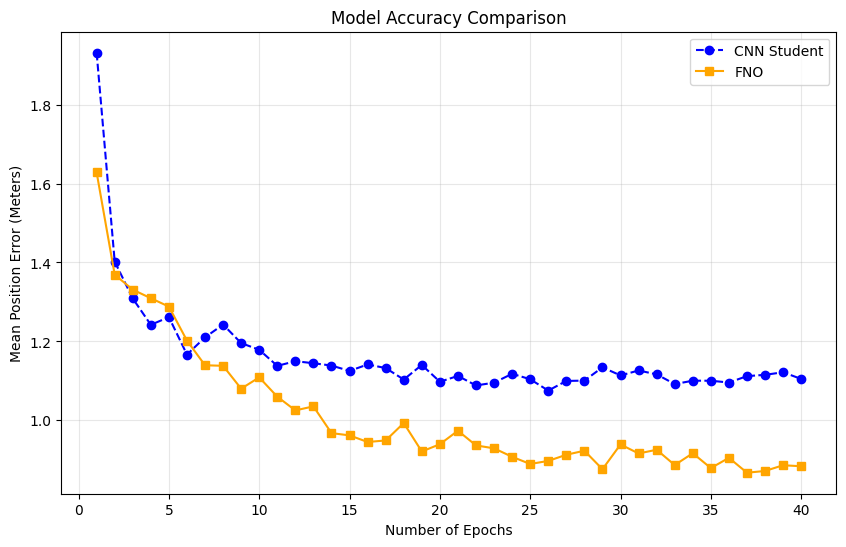

In [15]:
plot_results(cnn_history, fno_history)

As we can see, the CNN student starts with very low error even for a small number of epochs, this is because it has the guidance of the teacher model. The FNO, even without a Teacher, quickly reaches similar accuracy as the CNN student.

In [16]:
cnn_best_epoch, cnn_lowest = get_min_and_index(cnn_history)
fno_best_epoch, fno_lowest = get_min_and_index(fno_history)

print(f"CNN best epoch was {cnn_best_epoch} with a lowest error of {cnn_lowest} meters")
print(f"FNO best epoch was {fno_best_epoch} with a lowest error of {fno_lowest} meters")

CNN best epoch was 25 with a lowest error of 1.0754611304840482 meters
FNO best epoch was 36 with a lowest error of 0.8673690862376898 meters


Moving on to the 2nd test: Accuracy as a function of the size of the data.

For each amount of samples we will re-train both models (CNN student, FNO), this will simulate a case in which you have different amounts of data to train the models with

Here you can modify the sample sized which will be tested

In [3]:
chosen_sample_sizes = [1000, 2000, 3000, 5000, 10000]
chosen_epochs = 15 # number of epochs each model will be trained on the given dataset size
two_source_input_prob = 0 # probability that a sample will have 2 sources (default is 1)

Setup the 2nd test and run it

In [4]:
train_pool, val_dataset, test_tensors = setup_global_experiment(total_samples=int(np.round(chosen_sample_sizes[-1] * 1.2)), two_source_input_prob=two_source_input_prob)

In [5]:
results = run_efficiency_experiments(train_pool, val_dataset, test_tensors, sample_sizes = chosen_sample_sizes, epochs=chosen_epochs)


Training Teacher
Teacher Epoch 5/15 | Loss: 0.001661
Teacher Epoch 10/15 | Loss: 0.001385
Teacher Epoch 15/15 | Loss: 0.001302
Training complete, Validating now
Teacher Validation Loss: 0.001141

Experiment: Subset Size = 1000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.034433
Distill Epoch 10/15 | Loss: 0.012013
Distill Epoch 15/15 | Loss: 0.006362
Student Validation Loss: 0.006601
Training FNO...
FNO Epoch 5/15 | Loss: 0.024846
FNO Epoch 10/15 | Loss: 0.024836
FNO Epoch 15/15 | Loss: 0.022482

Experiment: Subset Size = 2000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.026411
Distill Epoch 10/15 | Loss: 0.006408
Distill Epoch 15/15 | Loss: 0.003641
Student Validation Loss: 0.003723
Training FNO...
FNO Epoch 5/15 | Loss: 0.024695
FNO Epoch 10/15 | Loss: 0.022308
FNO Epoch 15/15 | Loss: 0.022525

Experiment: Subset Size = 3000
Training CNN Student (Distilled from Oracle)...
Distill Epoch 5/15 | Loss: 0.004972
Distill Epoc

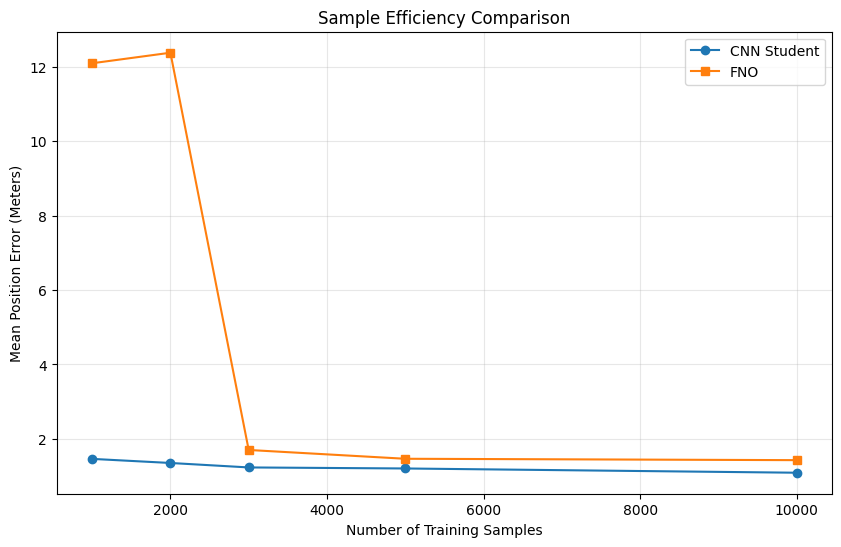

In [6]:
plot_sample_efficiency(results)

Similar to the previous test, we can see that for low amounts of data, the CNN student outperforms the FNO since it has the guidance of the teacher model, but soon the FNO catches up and achieves a similar error rate.

We will now perform the third test - testing the performance of both models when a sensor is malfunctioning

We will check what happens when you train your models on clean data, but then in the "money-time" one of the sensors is malfunctioning, meaning it provides no data at all or very noisy data

Choose which sensor to fail and the number of epochs the models will train

In [7]:
chosen_epochs_2 = 20
sensor_index = 1 # should be one of 0,1,2,3
total_samples_2 = 5000

Setting up and running the third experiment

In [8]:
acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken = run_sensor_malfunction_experiment(total_samples = total_samples_2, epochs=chosen_epochs_2, sensor_idx=sensor_index)


Running Sensor Malfunction Robustness Test
Training models on clean data
Teacher Epoch 5/20 | Loss: 0.002139
Teacher Epoch 10/20 | Loss: 0.001629
Teacher Epoch 15/20 | Loss: 0.001457
Teacher Epoch 20/20 | Loss: 0.001403
Training complete, Validating now
Teacher Validation Loss: 0.001377
Teacher Trained
Distill Epoch 5/20 | Loss: 0.004505
Distill Epoch 10/20 | Loss: 0.001398
Distill Epoch 15/20 | Loss: 0.000771
Distill Epoch 20/20 | Loss: 0.000480
Student Validation Loss: 0.002360
CNN Student Trained
FNO Epoch 5/20 | Loss: 0.003659
FNO Epoch 10/20 | Loss: 0.003105
Early stopping at epoch 13
 FNO Trained

 Generating Malfunction Test Set (Sensor 1 -> Dead/Noisy)...

 Evaluating...

Results Summary:
CNN | Clean Error: 1.15m | Broken Sensor Error: 3.51m
FNO | Clean Error: 1.39m | Broken Sensor Error: 2.14m


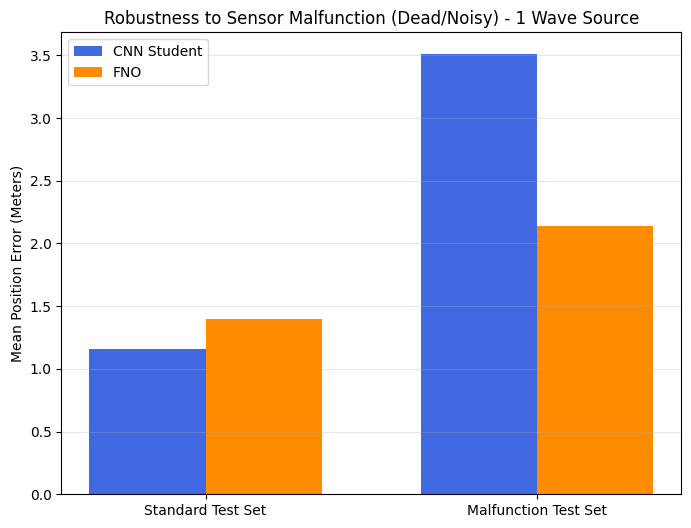

In [9]:
plot_robustness_comparison(acc_cnn_clean, acc_cnn_broken, acc_fno_clean, acc_fno_broken)

We can see that the FNO actually performs better when dealing with a malfunctioning sensor, essentially being more robust to this hard challenge.

Now we will perform the 4th tests which tests the performance of each model based on the level of noise the data contains

Generating Base Physics (5000 samples)...
Starting Noise Robustness Test
Testing Noise Level: 0.0... Done. (CNN: 0.99m | FNO: 0.94m)
Testing Noise Level: 0.005... Done. (CNN: 0.99m | FNO: 0.94m)
Testing Noise Level: 0.01... Done. (CNN: 1.00m | FNO: 0.95m)
Testing Noise Level: 0.05... Done. (CNN: 1.11m | FNO: 1.03m)
Testing Noise Level: 0.1... Done. (CNN: 1.23m | FNO: 1.29m)


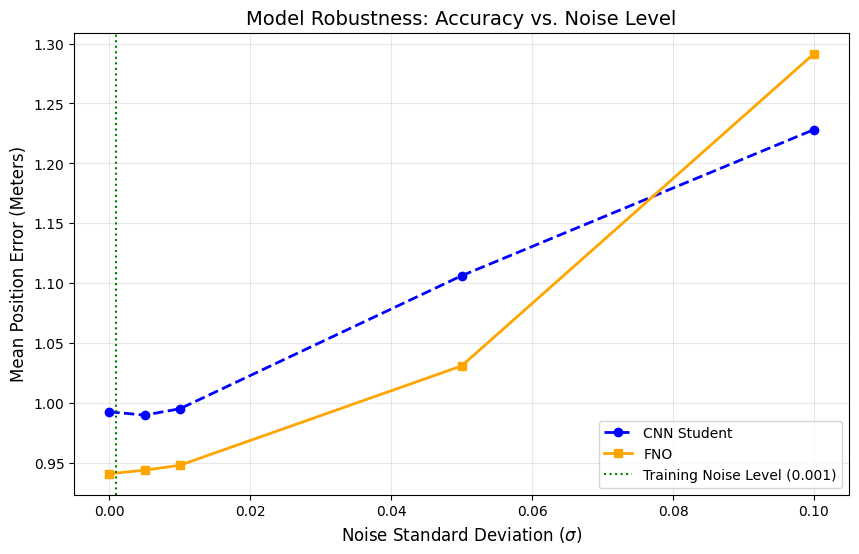

In [17]:
# run test
noise_results = run_noise_robustness_test(cnn, fno, num_samples=5000)

# plot the results
plot_noise_robustness(noise_results, train_noise_level=0.001)

We will now compare both models on:

1. Parameters Count
2. Inference Speed
3. Training time (per epoch)

In [18]:
comparison_table(cnn, fno, device)

METRIC                         | CNN             | FNO            
-----------------------------------------------------------------
Parameter Count                | 3,171,713       | 2,652,544      
Inference Speed (ms/sample)    | 1.1116          | 0.2832         
Training Time (est. sec/epoch) | 1.53            | 0.39           
